In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import radians, degrees, cos, sin, asin, sqrt

from scipy.stats import hmean

# from tqdm import tqdm_notebook as tqdm
# from tqdm import tqdm as tqdm_t

from tqdm._tqdm_notebook import tqdm_notebook as tqdm

import feather

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import keras
from keras.preprocessing import sequence
from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, LSTM, Dropout

from pathlib import Path

import utm

from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.ops import nearest_points

from multiprocessing import Pool

from matplotlib.colors import LogNorm

from sklearn.neighbors import KNeighborsRegressor

from sklearn.decomposition import PCA

import sys
sys.path.append("../../")

from pipeline.utils.stats import Stats

Using TensorFlow backend.


In [2]:
test_fraction = 4/5

In [3]:
messages = pd.read_csv("../../Trapeze_Data/first dump/VehicleMessages.csv", dtype={"isValid":float, "workCode":float,"tripCode":float}, parse_dates=[1], infer_datetime_format=True)


In [4]:
se = feather.read_dataframe("../../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_dwell.feather",
                            columns=["index",
                                     "segment_duration",
                                     "mean_durations_by_segment_code",
                                     "mean_durations_by_segment_code_and_hour",
                                     "mean_durations_by_segment_code_and_hour_and_day",
                                     "diff_segment_and_mean_by_segment_code",
                                     "diff_segment_and_mean_by_segment_code_and_hour_and_day",
                                     'line_distance',
                                     'to_centre_dist',
                                     'direction_degrees',
                                     'rain',
                                     'median_durations_by_segment_code_and_hour_and_day',
                                     'arrival_hour','arrival_day',
                                     "diff_percent_segment_and_mean_by_segment_code_and_hour_and_day",
                                     'date','workid',
                                     'actualArrival',
                                     'publicName',
                                     'segment_name',
                                     'prev_segment_code_1',
                                     'next_segment_code_1',
                                     'test','train',
                                     'timetable_segment_duration',
                                     'clock_direction_degrees', 'dry', 'weekend',
                                     'segment_code'
                                    ])
se = se.set_index(se.columns[0])

In [5]:
se['segment_duration'].mean()

46.03960549855144

In [8]:
stats = Stats(se[se['test']])



In [293]:
routes = pd.read_csv("../../Bournemouth GTFS/routes.csv")
shapes = pd.read_csv("../../Bournemouth GTFS/shapes.csv")
stops = pd.read_csv("../../Bournemouth GTFS/stops.txt").set_index('stop_id')
trips = pd.read_csv("../../Bournemouth GTFS/trips.txt")
performed_work = pd.read_csv("../../Trapeze_Data/first dump/PerformedWork.csv", parse_dates=[1])

In [296]:
# se['speed_mph'] = se['line_distance']*1000/se['segment_duration'] * 2.237

# se['speed_mph_baseline'] = se['line_distance']*1000/se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237

# And now for just segments:
se["diff_segment_and_mean_by_segment_code"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code"]
)
se["diff_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code_and_hour_and_day"]
)

se["diff_percent_segment_and_mean_by_segment_code"] = (
    se["diff_segment_and_mean_by_segment_code"]
    * 100
    / se["mean_durations_by_segment_code"]
)

se["diff_percent_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["diff_segment_and_mean_by_segment_code_and_hour_and_day"]
    * 100
    / se["mean_durations_by_segment_code_and_hour_and_day"]
)

segment_code_and_hour_and_day_groups = se[se["train"]].groupby(
        ["segment_code", "arrival_hour", "arrival_day"]
    )

std_diff_percent_segment_mean_by_segment_code_and_hour_and_day = (
    segment_code_and_hour_and_day_groups[
        "diff_percent_segment_and_mean_by_segment_code_and_hour_and_day"
    ]
    .std()
    .rename("std_diff_percent_segment_mean_by_segment_code_and_hour_and_day")
)
se = se.merge(
    std_diff_percent_segment_mean_by_segment_code_and_hour_and_day.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "arrival_day"],
    right_index=True,
)

In [297]:
se['prev_segment_name'] = se['prev_segment_code_1'].str[:-2]
se['next_segment_name'] = se['next_segment_code_1'].str[:-2]

In [298]:
trips_to_shapes_dict = {}

for route_id, route_group in trips.groupby('route_id'):
    matching_shapes = route_group.groupby('shape_id').first().index.values
    
    trips_to_shapes_dict[route_id] = matching_shapes


In [299]:
shapes_dict = {}

for shape_name, shape in tqdm(shapes.groupby('shape_id')):
    
    coords = np.empty((len(shape)+1, 2))
    
    for i, row in enumerate(shape[['latitude','longitude']].itertuples()):

        coords[i, :] = utm.from_latlon(row[1], row[2])[:2]
                        
    shapes_dict[shape_name] = LineString(coords)

          

In [300]:
segment_cache = {}

def find_length_by_name_route(segment_name, route_id, line_dist):
    
    line_dist = line_dist * 1000
    
    if segment_name in segment_cache:
        return segment_cache[segment_name]
    
    if type(route_id) == float:
        if np.isnan(route_id):
            
            segment_cache[segment_name] = line_dist
            
            return line_dist
    
    best_dist = np.inf
    lengths = []
    distances = []
    
    stop_codes = segment_name.split('_')

    try:
        stop_1_point = Point(utm.from_latlon(*stops.loc[stop_codes[0]][['stop_lat', 'stop_lon']].values)[:2])

        stop_2_point = Point(utm.from_latlon(*stops.loc[stop_codes[1]][['stop_lat', 'stop_lon']].values)[:2])
    except KeyError:
        
        segment_cache[segment_name] = line_dist
        
        return line_dist

    for shape_name in trips_to_shapes_dict[route_id]:

        shape = shapes_dict[shape_name]
        
        nearest_1 = nearest_points(shape, stop_1_point)[0]
        nearest_2 = nearest_points(shape, stop_2_point)[0]

        combined_dist = stop_1_point.distance(nearest_1) + stop_2_point.distance(nearest_2)
            
#         distances.append(combined_dist)
#         lengths.append(np.abs(shape.project(nearest_1) - shape.project(nearest_2)))

        # Find the cases where the points are close to the shape
        if (combined_dist) <= best_dist:
            best_dist = combined_dist
            
            distances.append(combined_dist)
            lengths.append(np.abs(shape.project(nearest_1) - shape.project(nearest_2)))
                
    if(best_dist >= 15):
        
        segment_cache[segment_name] = line_dist
        
        return line_dist

    # Take the mean of only those shapes where the points is very close to the shape
    new_length = np.mean(np.asarray(lengths)[np.asarray(distances) == best_dist])
    
    if (new_length == 0) | (new_length > 4000):
        
        segment_cache[segment_name] = line_dist
        
        return line_dist

    segment_cache[segment_name] = new_length

    return segment_cache[segment_name]

In [301]:
def find_length_by_geo_route(lat1, lon1, lat2, lon2, route_id, line_dist):
    
    # Try if line_dist < 20 just return line_dist...
    
    if line_dist == 0:
        return line_dist
    
    if type(route_id) == float:
        if np.isnan(route_id):
            
            return line_dist
    
    best_dist = np.inf
    lengths = []
    distances = []

    try: 
        stop_1_point = Point(utm.from_latlon(lat1, lon1)[:2])

        stop_2_point = Point(utm.from_latlon(lat2, lon2)[:2])
        
        shape_names = trips_to_shapes_dict[route_id]
        
        lengths = np.empty(len(shape_names))
        distances = np.empty(len(shape_names))
    
        for idx, shape_name in enumerate(shape_names):

            shape = shapes_dict[shape_name]

            nearest_1 = nearest_points(shape, stop_1_point)[0]
            nearest_2 = nearest_points(shape, stop_2_point)[0]
            
            distances[idx] = stop_1_point.distance(nearest_1) + stop_2_point.distance(nearest_2)
            lengths[idx] = np.abs(shape.project(nearest_1) - shape.project(nearest_2))
            
#             # Find the cases where the points are close to the shape
#             if (combined_dist) <= best_dist:
#                 best_dist = combined_dist
                
#                 distances.append(combined_dist)
#                 lengths.append(np.abs(shape.project(nearest_1) - shape.project(nearest_2)))

        best_dist = np.min(distances)
   
        # If the combined distance between the points and the best shape is over 10 meters
        # Or if the distance is more than a quater of the strieght line distance between the 
        # points just use the line distance.
        if (best_dist >= 10) or ((best_dist * 4) > line_dist):
            return line_dist

        # Take the mean of only those shapes where the points is very close to the shape
        new_length = np.mean(lengths[distances == best_dist])

    except: 
        return line_dist
    
    if (new_length == 0) | (new_length > line_dist*5) | (new_length < line_dist):
        
        return line_dist

    return new_length

In [302]:
se['route_id'] = routes.set_index('route_short_name').loc[se['publicName']]['route_id'].values


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [303]:
tqdm.pandas("My Bar")

In [304]:
se['real_length'] = se.progress_apply(lambda row: find_length_by_name_route(row['segment_name'], row['route_id'], row['line_distance']), axis=1)

In [305]:
se['speed_mph'] = se['real_length'] / se['segment_duration'] * 2.237

se['speed_mph_baseline'] = se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237

In [17]:
messages['timeReported'] = pd.to_datetime(messages['timeReported'])

In [18]:
messages['delta_time'] = messages['timeReported'] - messages.shift(1)['timeReported']
messages['time_seconds'] = messages['delta_time'] / np.timedelta64(1, 's')

In [19]:
messages['workCode'] = messages['workCode'].fillna(method="ffill")
messages['tripCode'] = messages['tripCode'].fillna(method="ffill")

In [20]:
messages['dateReported'] = messages['timeReported'].dt.date

In [21]:
messages['dateReported'] = pd.to_datetime(messages['dateReported'])

In [22]:
performed_work['tripCode'] = performed_work['tripCode'].replace([np.nan, np.inf], -1)

performed_work['tripCode'] = performed_work['tripCode'].astype(int)

In [23]:
messages = messages.reset_index().merge(performed_work[['workCode', 'tripCode', 'date', 'publicName']],
                            left_on=['workCode', 'tripCode', 'dateReported'], 
                            right_on=['workCode', 'tripCode', 'date'],
                           how="left").set_index("index")

In [306]:
# messages = messages.drop(columns=['date_x', 'publicName_x'])

In [25]:
messages = messages.reset_index().merge(routes[['route_short_name', 'route_id']], 
                                        left_on=['publicName'], 
                                        right_on=['route_short_name'], 
                                        how="left").set_index("index")

/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


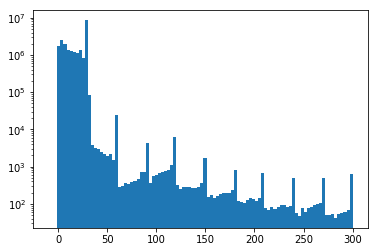

In [26]:
plt.hist((messages['delta_time'] / np.timedelta64(1, 's')).values, bins=100, range=(-10, 300));
plt.yscale("log")
plt.show()

In [27]:
print(f"Fraction under 31 seconds: {np.count_nonzero(messages['time_seconds'] < 31)/messages.shape[0]}")
      
print(f"Between 20 and 31 seconds: {np.count_nonzero((messages['time_seconds'] < 31) & (messages['time_seconds'] > 20))/messages.shape[0]}")
      
print(f"Between 10 and 31 seconds: {np.count_nonzero((messages['time_seconds'] < 31) & (messages['time_seconds'] > 10))/messages.shape[0]}")
      
print(f"Between 5 and 31 seconds: {np.count_nonzero((messages['time_seconds'] < 31) & (messages['time_seconds'] > 5))/messages.shape[0]}")
      

Fraction under 31 seconds: 0.9922313547349763
Between 20 and 31 seconds: 0.4873540276156894
Between 10 and 31 seconds: 0.6685176447865044
Between 5 and 31 seconds: 0.7989372016388877


In [28]:
messages['delta_lon'] = messages['lon'] - messages.shift(1)['lon']
messages['delta_lat'] = messages['lat'] - messages.shift(1)['lat']

In [29]:
messages['msg'].unique()

array(['inPosition', 'InTripEnd', 'InTripStart', 'InPointArrive',
       'InPointDepart'], dtype=object)

In [30]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [31]:
messages['delta_distance'] = haversine_np(messages['lon'], messages['lat'], messages['lon'].shift(1), messages['lat'].shift(1)) * 1000


In [32]:
messages = messages.dropna(subset=['lon', 'lat'])

messages = messages[(messages['time_seconds'] > 0)]

In [33]:
messages['lon_next'] = messages['lon'].shift(1)
messages['lat_next'] = messages['lat'].shift(1)


In [ ]:
num_partitions = 20
num_cores = 5

def parallelize_dataframe(df, func, args):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    
    # This line is fidly, we make a list where each item is a tuple of 
    # a bit of the dataframe and whatever is passed in as args. 
    # Then starmap unpacks that tuple so each copy of func gets it's 
    # little bit of the dataframe and the right args to do it's job. 
    # All this to avoid globals! 
    all_args = [(split,) + args for split in df_split]
    
    df = pd.concat(pool.starmap(func, all_args))
    pool.close()
    pool.join()
    return df

In [ ]:
messages.iloc[1510485]


In [ ]:
def find_dist(messages):

    messages['true_distance'] = messages[['lon', 'lat', 
                                          'lon_next', 'lat_next', 
                                          'route_id', 'delta_distance'
                                         ]].apply(lambda row: find_length_by_geo_route(*row[['lat', 'lon',
                                                                                          'lat_next', 
                                                                                           'lon_next',
                                                                                           'route_id',
                                                                                           'delta_distance'
                                                                                          ]]), axis=1)

    return messages



In [ ]:
messages = parallelize_dataframe(messages, find_dist, ())

In [34]:
messages['delta_speed'] = messages['delta_distance']/messages['time_seconds']
# messages['delta_speed'] = messages['true_distance']/messages['time_seconds']

In [35]:
messages['speed_mph'] = messages['delta_speed'] * 2.237

In [152]:
# messages.to_csv("messages_with_true_dist.csv")

messages = pd.read_csv("messages_with_true_dist.csv")

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# messages.to_csv("messages_with_true_dist.csv")

In [153]:
print(f"total: {len(messages)}")

print(f"changed: {np.count_nonzero(messages['true_distance'] != messages['delta_distance'])}")
      
print(f"is close: {np.count_nonzero(np.isclose(messages['true_distance'], messages['delta_distance']))}")

total: 21434532
changed: 5660938
is close: 15777464


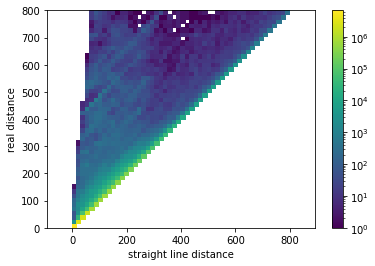

In [154]:
plt.hist2d(messages['delta_distance'], messages['true_distance'], bins=[50,50], range=[[0,800],[0,800]], norm=LogNorm())
plt.axis('equal')
plt.xlabel("straight line distance")
plt.ylabel("real distance")
plt.colorbar()

In [155]:
(np.count_nonzero(messages['delta_distance'] == messages['true_distance'])/len(messages))*100

73.58963564028363

total: 3920087
changed: 2785921
is close: 1134166


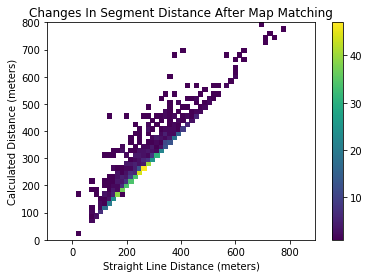

In [223]:
print(f"total: {len(se)}")

print(f"changed: {np.count_nonzero(se['real_length'] != se['line_distance']*1000)}")
      
print(f"is close: {np.count_nonzero(np.isclose(se['real_length'], se['line_distance']*1000))}")

just_segs = se.groupby('segment_name').first()
      
plt.hist2d(just_segs['line_distance']*1000, just_segs['real_length'], bins=[50,50], range=[[0,800],[0,800]], cmin=1)
# plt.hist2d(just_segs['line_distance']*1000, just_segs['real_length'], bins=[50,50], range=[[0,800],[0,800]], norm=LogNorm())
plt.axis('equal')
plt.xlabel("Straight Line Distance (meters)")
plt.ylabel("Calculated Distance (meters)")
plt.title("Changes In Segment Distance After Map Matching")
plt.colorbar()
plt.savefig("GPS:distances hist.pdf", bbox_inches="tight")

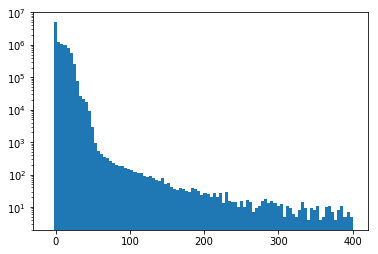

In [37]:
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 20)]['speed_mph'], bins=100, range=(-10,400));
plt.yscale("log")

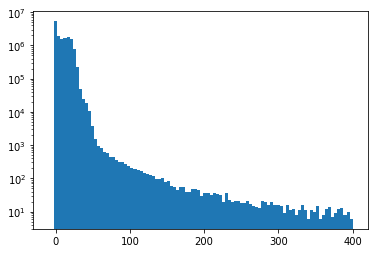

In [38]:
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 5)]['speed_mph'], bins=100, range=(-10,400));
plt.yscale("log")

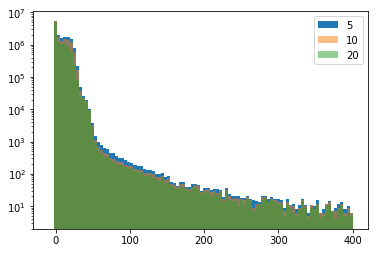

In [39]:
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 5)]['speed_mph'], bins=100, range=(-10,400), label="5");
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 10)]['speed_mph'], bins=100, range=(-10,400), label="10", alpha=0.5);
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 20)]['speed_mph'], bins=100, range=(-10,400), label="20", alpha=0.5);
plt.yscale("log")
plt.legend()

In [40]:
np.sum(messages[(messages['msg'].isin(['inPosition', 'InPointArrive']))]['time_seconds'])

431833852.0

In [41]:
np.sum(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['speed_mph'] < 3)]['time_seconds'])

226814593.0

In [42]:
226289342.0/431833852.0*100

52.40194601510768

In [156]:
messages['prev_speed_mph'] = messages.shift(1)['speed_mph']
messages['next_speed_mph'] = messages.shift(-1)['speed_mph']

In [157]:
messages['jitter'] = [False]*messages.shape[0]

messages['jitter'] = (messages['speed_mph'] > 75) & \
    (((messages['prev_speed_mph'] > 75) & (messages['next_speed_mph'] < 50)) | \
     ((messages['next_speed_mph'] > 75) & (messages['prev_speed_mph'] < 50)))

In [158]:
messages['inout'] = ""
messages.loc[messages['msg'] == "InPointArrive", "inout"] = "in"
messages.loc[messages['msg'] == "InPointDepart", "inout"] = "out"
messages['inout'] = messages['inout'].replace("", np.nan)
messages['inout'] = messages['inout'].fillna(method="ffill")

In [225]:
messages.loc[messages['msg'].isin(['inPosition', 'InPointArrive']), 'inout'].value_counts()

in     9429412
out    7870405
Name: inout, dtype: int64

In [224]:
messages['jitter'].value_counts()

False    21426427
True         8105
Name: jitter, dtype: int64

In [160]:
messages['segment_name'] = messages['stopCode'].fillna(method="ffill").shift(1) + "_" + messages['stopCode'].fillna(method="bfill") 

In [161]:
filtered = messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 5) & (messages['jitter'] == False) & (messages['speed_mph'] != np.inf) & (messages['inout'] == "out")]


In [226]:
filtered.shape

(7098429, 32)

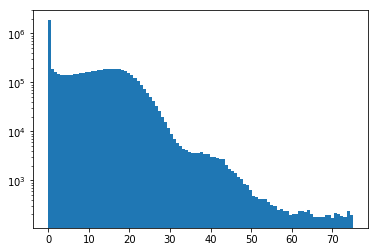

In [162]:
plt.hist(filtered['speed_mph'], bins=100, range=(0,75));
plt.yscale("log")

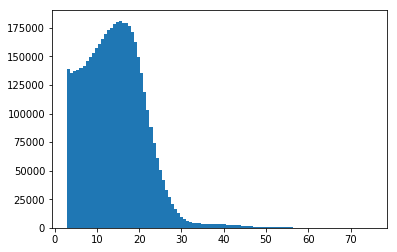

In [228]:
plt.hist(filtered['speed_mph'], bins=100, range=(3,75));
# plt.yscale("log")

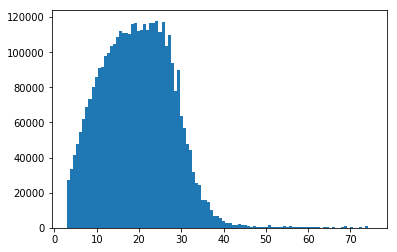

In [229]:
plt.hist(se['speed_mph'], bins=100, range=(3,75));

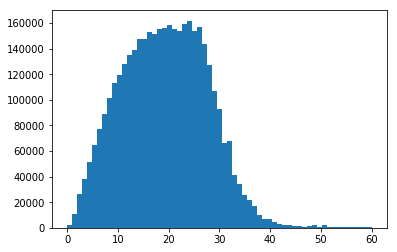

In [64]:
plt.hist(se['speed_mph'], range=(0, 60), bins=61);

In [307]:
se['mean_speed_mph_by_segment_code'] = se['real_length']/se['mean_durations_by_segment_code'] * 2.237

se['mean_speed_mph_by_segment_code_hour'] = se['real_length']/se['mean_durations_by_segment_code_and_hour'] * 2.237

se['speed_mph_diff_mean_to_hour'] = se['mean_speed_mph_by_segment_code_hour'] - se['mean_speed_mph_by_segment_code']


In [ ]:
just_one = se[se['arrival_day'] < 5].groupby(["segment_name", "arrival_hour"]).first()

In [ ]:
just_one = just_one.reset_index().merge(all_stats_df, left_on=['segment_name','arrival_hour'], right_on=['seg_name','hours']) # .set_index(['segment_name','arrival_hour'])

just_one = just_one.dropna(axis=0)

In [ ]:
data_to_fit = just_one[['slow_fraction', 'fast_mean', 'total_mean',
                        'clipped_hmean','clipped_mean','freq',
                        'fast_hmean', 'real_length', ]].values
#                         'direction_degrees', 'to_centre_dist']].values

poly = PolynomialFeatures(2)

expanded_data = poly.fit_transform(data_to_fit)

names = poly.get_feature_names(['slow_fraction', 'fast_mean', 'total_mean',
                                'clipped_hmean','clipped_mean','freq',
                                'fast_hmean','real_length', ])
                                #'direction_degrees', 'to_centre_dist'])


In [55]:
def prep_training_data(data, target, cut_point):

#     cut_point = int(len(data)*test_fraction)
    
    train_data = data[:cut_point,:]
    test_data = data[cut_point:,:]
    
    test_mask = np.zeros(data.shape[0]).astype(bool)
    test_mask[cut_point:] = True

    train_target = target[:cut_point]
    test_target = target[cut_point:]
    
    scaler_target = preprocessing.StandardScaler().fit(train_target[:, None])

#     scaler_target = preprocessing.MinMaxScaler().fit(train_target[:, None])


    train_target_scaled = scaler_target.transform(train_target[:, None]).astype(np.float32)
    test_target_scaled = scaler_target.transform(test_target[:, None]).astype(np.float32)
    
    data_scaler = preprocessing.StandardScaler()

    train_data_scaled = data_scaler.fit_transform(train_data).squeeze()
    test_data_scaled = data_scaler.transform(test_data).squeeze()

    return train_data_scaled, test_data_scaled, train_target_scaled, test_target_scaled, scaler_target


In [201]:
def prep_training_data_days(data, target, days, valid_mask):

    first_day_test = se.loc[se["test"], "date"].min()
    
    train_days = 0
    count = 0
    
    # Use the stop events to work out how to make a mask that has exactly the right number of days in it.
    while train_days != days and count != 10:

        train = se.loc[
            se["date"].isin(
                pd.date_range(
                    start=(first_day_test - pd.Timedelta(f"{days + 1 + count} days")),
                    periods=(days + 1 + count),
                )
            )
        ]

        train_days = len(train.groupby("date").first())
        count += 1

    
    train_days_mask = se["date"].isin(
                pd.date_range(
                    start=(first_day_test - pd.Timedelta(f"{days + 1 + count} days")),
                    periods=(days + 1 + count),
                )
            )
    
    train_data = data[valid_mask & train_days_mask,:]
    test_data = data[valid_mask & se['test'],:]
    
    train_target = target[valid_mask & train_days_mask]
    test_target = target[valid_mask & se['test']]
    
    scaler_target = preprocessing.StandardScaler().fit(train_target[:, None])

    train_target_scaled = scaler_target.transform(train_target[:, None]).astype(np.float32)
    test_target_scaled = scaler_target.transform(test_target[:, None]).astype(np.float32)
    
    data_scaler = preprocessing.StandardScaler()

    train_data_scaled = data_scaler.fit_transform(train_data).squeeze()
    test_data_scaled = data_scaler.transform(test_data).squeeze()

    return train_data_scaled, test_data_scaled, train_target_scaled, test_target_scaled, scaler_target


In [ ]:
(train_data_scaled, test_data_scaled, 
 train_target_scaled, test_target_scaled, 
 scaler_target) = prep_training_data(expanded_data, just_one['mean_speed_mph_by_segment_code_hour'].values, int(len(expanded_data)*test_fraction))

test_target_truth = scaler_target.inverse_transform(test_target_scaled).squeeze()

lr = LinearRegression()
# lr = Lasso()

lr.fit(train_data_scaled, train_target_scaled)

test_y_scaled = lr.predict(test_data_scaled)

test_y = scaler_target.inverse_transform(test_y_scaled)

test_target_truth = scaler_target.inverse_transform(test_target_scaled)

plt.scatter(test_target_truth, test_y, marker=".", alpha=0.3)
plt.xlabel("true target (mph)")
plt.ylabel("prediction target (mph)")
plt.ylim(-5,35)

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))


In [ ]:
ordered_names = np.array(names).squeeze()[np.argsort(np.abs(lr.coef_))].squeeze()

ordered_coef = np.array(lr.coef_).squeeze()[np.argsort(np.abs(lr.coef_))].squeeze()

display(list(zip(ordered_names, ordered_coef))[::-1])

In [ ]:
(train_data_scaled, test_data_scaled, 
 train_target_scaled, test_target_scaled, 
 scaler_target) = prep_training_data(expanded_data, just_one['mean_speed_mph_by_segment_code_hour'].values, int(len(expanded_data)*test_fraction))

ar = ARDRegression()
# lr = Lasso()

ar.fit(train_data_scaled, train_target_scaled)

test_y_scaled = ar.predict(test_data_scaled)

test_y = scaler_target.inverse_transform(test_y_scaled)

test_target_truth = scaler_target.inverse_transform(test_target_scaled)

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))


In [ ]:
test_y_scaled = ar.predict(test_data_scaled)

test_y = scaler_target.inverse_transform(test_y_scaled)

test_target_truth = scaler_target.inverse_transform(test_target_scaled)

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))

plt.scatter(test_target_truth, test_y, marker=".", alpha=0.3)
plt.xlabel("true target (mph)")
plt.ylabel("prediction target (mph)")
plt.ylim(-5,35)


In [ ]:
ordered_names = np.array(names).squeeze()[np.argsort(np.abs(ar.coef_))].squeeze()

ordered_coef = np.array(ar.coef_).squeeze()[np.argsort(np.abs(ar.coef_))].squeeze()

display(list(zip(ordered_names, ordered_coef))[::-1])

In [330]:
def create_simple_model(input_shape, dropout, NN, use_linear):

    # with help from: https://keras.io/getting-started/functional-api-guide/

    # Headline input: meant to receive road time series.
    main_input = Input(shape=[input_shape], dtype="float32", name="input")

    for index, layer in enumerate(NN):
        if(index == 0):
            x = Dense(layer, activation="relu")(main_input)
            x = Dropout(rate=dropout)(x)
        if index == len(NN)-1:
            x = Dense(layer, activation="relu")(x)
        else:
            x = Dense(layer, activation="relu")(x)
            x = Dropout(rate=dropout)(x)

#     # We stack a deep densely-connected network on top
#     x = Dense(128, activation="relu")(main_input)
#     x = Dropout(rate=dropout)(x)
#     x = Dense(64, activation="relu")(x)
#     x = Dropout(rate=dropout)(x)
#     x = Dense(32, activation="relu")(x)
#     x = Dropout(rate=dropout)(x)
#     x = Dense(32, activation="relu")(x)
#     x = Dropout(rate=dropout)(x)
#     x = Dense(12, activation="relu")(x)
#     x = Dropout(rate=dropout)(x)

    # And finally we add the main output layer
    if use_linear:
        main_output = Dense(1, activation="linear", name="main_output")(x)
    else: 
        main_output = Dense(1, activation="tanh", name="main_output")(x)

    model = Model(
        inputs=[main_input], outputs=[main_output]
    )

    model.summary()

    return model

In [ ]:
(train_data_scaled, test_data_scaled, 
 train_target_scaled, test_target_scaled, 
 scaler_target) = prep_training_data(data_to_fit, just_one['mean_speed_mph_by_segment_code_hour'], int(len(data_to_fit)*test_fraction))

model = create_simple_model(
        (train_data_scaled.shape[1]),
        0.1)

Path(f"GPS_models").mkdir(parents=True, exist_ok=True)

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
    keras.callbacks.ModelCheckpoint(
        filepath=f"GPS_models/simple.h5",
        monitor="val_loss",
        save_best_only=True,
    ),
]

# model.compile(optimizer="rmsprop", loss="mean_absolute_error")
model.compile(optimizer="rmsprop", loss="mse")
model.fit(
    train_data_scaled,
    train_target_scaled,
    epochs=100,
    callbacks=callbacks_list,
    batch_size=32,
    validation_data=(test_data_scaled, test_target_scaled),
)

test_y_scaled = model.predict(test_data_scaled)

test_y = scaler_target.inverse_transform(test_y_scaled)

In [ ]:
test_target_truth = scaler_target.inverse_transform(test_target_scaled).squeeze()

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))

plt.scatter(test_target_truth, test_y, marker=".", alpha=0.3)
plt.xlabel("true target (mph)")
plt.ylabel("prediction target (mph)")
plt.ylim(-5,35)

In [218]:
filtered['time_seconds'].mean()

25.030280221158794

### Plan

- Calc the stats for all the segments
- Load up the means by hour of the day and daytype for each of these segment names
- Try to find a way to predict the spead of the segment by hour using the stats
- Get the stats for each indivual event, not just the bulk averages, 
    - Do the same for the last hour on that segment and think about fast ways to do prev/next as well
- Try to find the stats with the highest and lowest variance (forcus on those with lower variance)
- Is there enough data? 

In [164]:
segments_dict = {}

segments = filtered.groupby('segment_name')

for seg_name, segment in segments:
    
     df = segment.set_index("timeReported")[['speed_mph', 'time_seconds']]
        
     df.index = pd.to_datetime(df.index)
    
     segments_dict[seg_name] = df

In [165]:
matrix_width = 13

In [166]:
se_gps_data_hour = np.zeros((se.shape[0], matrix_width)).astype(np.float32)
se_gps_data_20mins = np.zeros((se.shape[0], matrix_width)).astype(np.float32)

In [167]:
se_gps_data_hour_prev_next = np.zeros((se.shape[0], matrix_width)).astype(np.float32)

In [168]:
for idx, row in enumerate(tqdm(se[['actualArrival', 'segment_name']].itertuples())):
    
    gps_tracks = segments_dict[row[2]]
    
    relevant = gps_tracks[(gps_tracks.index > row[1] - pd.Timedelta(f"80 min")) & (gps_tracks.index < row[1] - pd.Timedelta(f"20 min"))]
    
    if(len(relevant) == 0):
        se_gps_data_hour[idx,0] = row[0]
        continue
    
    slow_time = np.sum(relevant[relevant['speed_mph'] <= 3]['time_seconds'])
    total_time = np.sum(relevant['time_seconds'])
    fast = relevant[relevant['speed_mph'] > 3]
    fast_speeds = fast['speed_mph'].values
    fast_times = fast['time_seconds'].values
    fast_time = total_time - slow_time
    relevant_speeds = relevant['speed_mph'].values
    relvant_times = relevant['time_seconds'].values
    
    row_data = np.empty(matrix_width).astype(np.float32)
    
    row_data[0] = row[0]
    row_data[1] = slow_time/total_time
    row_data[2] = hmean(fast_speeds)
    row_data[3] = np.sum(fast_speeds * fast_times)/fast_time
    row_data[4] = np.sum(relevant_speeds * relvant_times)/total_time
    row_data[5] = len(relevant)
    row_data[6] = len(fast_times)

    if len(fast_times) > 0:
        row_data[7], row_data[8] = np.quantile(fast_speeds, [0.5, 0.75])
    else:
        row_data[7] = np.nan
        row_data[8] = np.nan
    
    row_data[9], row_data[10] = np.quantile(relevant_speeds, [0.5, 0.75])
    row_data[11] = np.max(relevant_speeds)
    row_data[12] = np.std(fast_speeds)
    
    se_gps_data_hour[idx, :] = row_data


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/scipy/stats/stats.py:377: RuntimeWarning: invalid value encountered in double_scalars
  return size / np.sum(1.0 / a, axis=axis, dtype=dtype)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [75]:
for idx, row in enumerate(tqdm(se[['actualArrival', 'segment_name']].itertuples())):
    
    gps_tracks = segments_dict[row[2]]
    
    relevant = gps_tracks[(gps_tracks.index > row[1] - pd.Timedelta(f"40 min")) & (gps_tracks.index < row[1] - pd.Timedelta(f"20 min"))].values
    
    if(len(relevant) == 0):
        se_gps_data_20mins[idx,0] = row[0]
        continue
        
    slow_time = np.sum(relevant[relevant['speed_mph'] <= 3]['time_seconds'])
    total_time = np.sum(relevant['time_seconds'])
    fast = relevant[relevant['speed_mph'] > 3]
    fast_speeds = fast['speed_mph'].values
    fast_times = fast['time_seconds'].values
    fast_time = total_time - slow_time
    relevant_speeds = relevant['speed_mph'].values
    relvant_times = relevant['time_seconds'].values
    
    row_data = np.empty(matrix_width).astype(np.float32)
    
    row_data[0] = row[0]
    row_data[1] = slow_time/total_time
    row_data[2] = hmean(fast_speeds)
    row_data[3] = np.sum(fast_speeds * fast_times)/fast_time
    row_data[4] = np.sum(relevant_speeds * relvant_times)/total_time
    row_data[5] = len(relevant)
    row_data[6] = len(fast_times)

    if len(fast_times) > 0:
        row_data[7], row_data[8] = np.quantile(fast_speeds, [0.5, 0.75])
    else:
        row_data[7] = np.nan
        row_data[8] = np.nan
    
    row_data[9], row_data[10] = np.quantile(relevant_speeds, [0.5, 0.75])
    row_data[11] = np.max(relevant_speeds)
    row_data[12] = np.std(fast_speeds)
    
    se_gps_data_20mins[idx, :] = row_data
    

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [169]:
for idx, row in enumerate(tqdm(se[['actualArrival', 'segment_name', 'prev_segment_name', 'next_segment_name']].itertuples())):
    
    gps_tracks = segments_dict[row[2]]
    
    relevant_current = gps_tracks[(gps_tracks.index > row[1] - pd.Timedelta(f"80 min")) & (gps_tracks.index < row[1] - pd.Timedelta(f"20 min"))]
    
    if (row[3] != '') & (row[3] in segments_dict):
        gps_tracks_prev = segments_dict[row[3]]
        
        relevant_prev = gps_tracks_prev[(gps_tracks_prev.index > row[1] - pd.Timedelta(f"80 min")) & (gps_tracks_prev.index < row[1] - pd.Timedelta(f"20 min"))]
    else:
        relevant_prev = [] 
        
    if (row[4] != '') & (row[4] in segments_dict):
        gps_tracks_next = segments_dict[row[4]]
    
        relevant_next = gps_tracks_next[(gps_tracks_next.index > row[1] - pd.Timedelta(f"80 min")) & (gps_tracks_next.index < row[1] - pd.Timedelta(f"20 min"))]
    else: 
        relevant_next = []
        
    to_concat = []
    
    for chunk in [relevant_current, relevant_prev, relevant_next]:
        if len(chunk) > 0:
            to_concat.append(chunk)
            
    if len(to_concat) == 0:
        se_gps_data_hour_prev_next[idx,0] = row[0]
        continue
        
    relevant = pd.concat(to_concat)
    
#     if(len(relevant) == 0):
#         se_gps_data_hour_prev_next[idx,0] = row[0]
#         continue
        
    slow_time = np.sum(relevant[relevant['speed_mph'] <= 3]['time_seconds'])
    total_time = np.sum(relevant['time_seconds'])
    fast = relevant[relevant['speed_mph'] > 3]
    fast_speeds = fast['speed_mph'].values
    fast_times = fast['time_seconds'].values
    fast_time = total_time - slow_time
    relevant_speeds = relevant['speed_mph'].values
    relvant_times = relevant['time_seconds'].values
    
    row_data = np.empty(matrix_width).astype(np.float32)
    
    row_data[0] = row[0]
    row_data[1] = slow_time/total_time
    row_data[2] = hmean(fast_speeds)
    row_data[3] = np.sum(fast_speeds * fast_times)/fast_time
    row_data[4] = np.sum(relevant_speeds * relvant_times)/total_time
    row_data[5] = len(relevant)
    row_data[6] = len(fast_times)

    if len(fast_times) > 0:
        row_data[7], row_data[8] = np.quantile(fast_speeds, [0.5, 0.75])
    else:
        row_data[7] = np.nan
        row_data[8] = np.nan
    
    row_data[9], row_data[10] = np.quantile(relevant_speeds, [0.5, 0.75])
    row_data[11] = np.max(relevant_speeds)
    row_data[12] = np.std(fast_speeds)
    
    se_gps_data_hour_prev_next[idx, :] = row_data
    

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


In [170]:
np.save("se_gps_features_20min_80min_inout_fixed_true_speed", se_gps_data_hour)

In [ ]:

np.save("se_gps_features_20min_40min_inout_fixed", se_gps_data_20mins)

In [171]:
np.save("se_gps_features_20min_80min_prev_next_inout_fixed_true_speed", se_gps_data_hour_prev_next)

In [ ]:
# se_gps_data_hour = np.load("se_gps_features_20min_80min_inout_fixed_true_speed.npy")
# se_gps_data_20mins = np.load("se_gps_features_20min_40min_inout_fixed.npy", )
# se_gps_data_hour_prev_next = np.load("se_gps_features_20min_80min_prev_next_inout_fixed_true_speed.npy", )

 ### Key to columns
 
-  0 -> Index
-  1 -> slow_fraction (time)
-  2 -> harmonic mean speed (fast, not weighted)
-  3 -> mean speed (fasted weighted dby time)
-  4 -> mean speed (all weighted dby time)
-  5 -> number of relevant readings
-  6 -> number of fast readings
-  7 -> median fast
-  8 -> 75th percentile (fast)
-  9 -> median all
-  10 -> 75th percentile (all)
-  11 -> Max speed
-  12 -> standard deviation fast speeds
 
 

In [96]:
data = np.hstack((se_gps_data_hour_prev_next[:,1:], se[['real_length', 
                                                            'direction_degrees', 
                                                            "to_centre_dist",
                                                           'rain',
                                                           'arrival_hour',
                                                           'arrival_day']].values))

df_cors = pd.DataFrame(data=np.hstack((data, se[['speed_mph']].values)),
                    columns=['slow_fraction', 'fast_hmean', 'fast_mean', 'total_mean',
                                'freq_total',
                                'freq_fast',
                               'fast_median', 'fast_75th percential',
                              'total_median', 'total_75th percential', 'max', 'std',
                             'real_length', 'direction_degrees', "to_centre_dist",
                                                           'rain',
                                                           'arrival_hour',
                                                           'arrival_day','speed_mph'])

cors = df_cors[df_cors['freq_fast'] >= 10].corr()

In [97]:
cors

,slow_fraction,fast_hmean,fast_mean,total_mean,freq_total,freq_fast,fast_median,fast_75th percential,total_median,total_75th percential,max,std,real_length,direction_degrees,to_centre_dist,rain,arrival_hour,arrival_day,speed_mph
slow_fraction,1.000000,-0.442384,-0.016944,-0.101059,0.303115,0.032602,-0.382185,-0.277706,-0.726955,-0.549655,0.023791,0.025007,0.007807,-0.073490,0.056266,-0.009064,-0.022689,-0.015588,-0.118985
fast_hmean,-0.442384,1.000000,0.075459,0.120259,-0.352249,-0.256651,0.868918,0.714348,0.835032,0.768264,-0.010895,-0.012660,-0.039705,0.011115,0.015355,0.013833,-0.066586,0.014993,0.218893
fast_mean,-0.016944,0.075459,1.000000,0.969980,-0.026257,-0.024816,0.074618,0.070954,0.059134,0.066144,0.727367,0.824269,-0.002517,0.010177,0.023939,0.000372,-0.014896,0.000449,0.015747
total_mean,-0.101059,0.120259,0.969980,1.000000,-0.053959,-0.030653,0.112633,0.099916,0.126229,0.117126,0.669403,0.767772,-0.003253,0.015392,0.019120,0.000123,-0.012433,0.001836,0.028061
freq_total,0.303115,-0.352249,-0.026257,-0.053959,1.000000,0.928832,-0.359567,-0.327228,-0.387995,-0.387281,0.017147,0.012263,0.135797,-0.155788,-0.192583,-0.022869,-0.017694,-0.032736,-0.141950
freq_fast,0.032602,-0.256651,-0.024816,-0.030653,0.928832,1.000000,-0.265226,-0.255504,-0.191257,-0.223257,0.007964,0.003234,0.137177,-0.151528,-0.254368,-0.026618,-0.020346,-0.037814,-0.114343
fast_median,-0.382185,0.868918,0.074618,0.112633,-0.359567,-0.265226,1.000000,0.840192,0.848304,0.876314,-0.010144,-0.009789,-0.043736,0.013491,0.030019,0.011212,-0.064000,0.008228,0.222838
fast_75th percential,-0.277706,0.714348,0.070954,0.099916,-0.327228,-0.255504,0.840192,1.000000,0.669848,0.907133,-0.007572,-0.004569,0.030820,-0.027995,0.089241,0.007358,-0.057837,-0.002462,0.219115
total_median,-0.726955,0.835032,0.059134,0.126229,-0.387995,-0.191257,0.848304,0.669848,1.000000,0.842482,-0.018709,-0.019671,-0.048896,0.037344,-0.012460,0.012136,-0.034402,0.016045,0.207256
total_75th percential,-0.549655,0.768264,0.066144,0.117126,-0.387281,-0.223257,0.876314,0.907133,0.842482,1.000000,-0.014069,-0.012305,-0.003346,0.004169,0.034806,0.009007,-0.044306,0.005869,0.222241


In [99]:
# For version 3

cors['speed_mph'].abs().sort_values().index[::-1]

Index(['speed_mph', 'fast_median', 'total_75th percential',
       'fast_75th percential', 'fast_hmean', 'total_median', 'freq_total',
       'slow_fraction', 'freq_fast', 'real_length', 'direction_degrees',
       'total_mean', 'fast_mean', 'to_centre_dist', 'arrival_hour', 'max',
       'std', 'arrival_day', 'rain'],
      dtype='object')

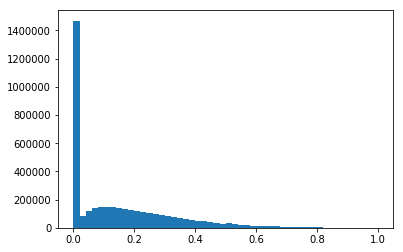

In [100]:
plt.hist(se_gps_data_hour_prev_next[:,1], bins=50, range=(0,1));

/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


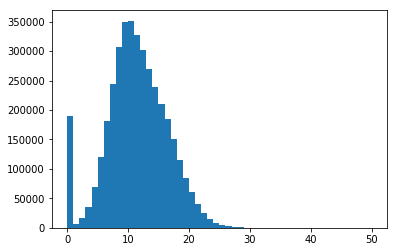

In [101]:
plt.hist(se_gps_data_hour_prev_next[:,4], bins=50, range=(0,50));

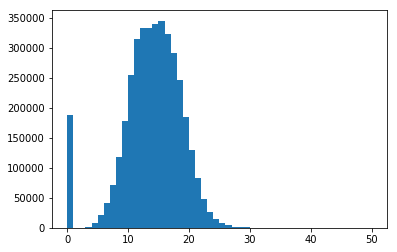

In [103]:
plt.hist(se_gps_data_hour_prev_next[:,7], bins=50, range=(0,50));

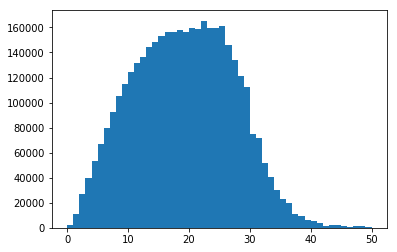

In [104]:
plt.hist(se['speed_mph'], bins=50, range=(0,50));

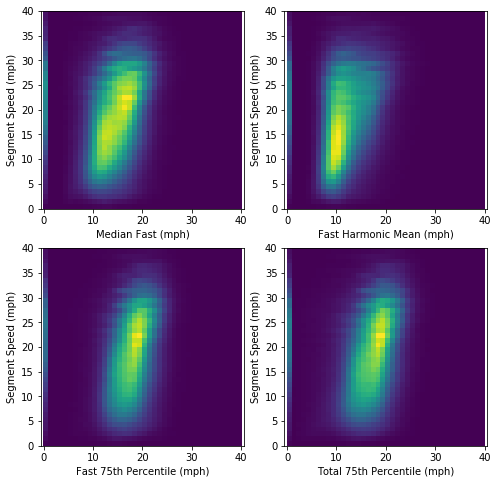

In [317]:
c_min = 5
c_max = 10000
bin_size = 40
freq_min = 0

fig = plt.figure(figsize=(8,8))

stats_filtered = se_gps_data_hour_prev_next[se_gps_data_hour_prev_next[:,5] >= freq_min]
events = se[se_gps_data_hour_prev_next[:,5] >= freq_min]

plt.subplot(2, 2, 1)
plt.hist2d(stats_filtered[:,7], events['speed_mph'], range=[[0,40],[0,40]], bins=[bin_size,bin_size], linewidth=0,rasterized=True)
plt.ylabel("Segment Speed (mph)")
plt.xlabel("Median Fast (mph)")
plt.axis('equal')

plt.subplot(2,2,2)
plt.hist2d(stats_filtered[:,2], events['speed_mph'], range=[[0,40],[0,40]], bins=[bin_size,bin_size], linewidth=0,rasterized=True)
plt.ylabel("Segment Speed (mph)")
plt.xlabel("Fast Harmonic Mean (mph)")
plt.axis('equal')

plt.subplot(2,2,3)
plt.hist2d(stats_filtered[:,8], events['speed_mph'], range=[[0,40],[0,40]], bins=[bin_size,bin_size], linewidth=0,rasterized=True)
plt.ylabel("Segment Speed (mph)")
plt.xlabel("Fast 75th Percentile (mph)")
plt.axis('equal')

plt.subplot(2,2,4)
plt.hist2d(stats_filtered[:,10], events['speed_mph'], range=[[0,40],[0,40]], bins=[bin_size,bin_size], linewidth=0,rasterized=True)
plt.ylabel("Segment Speed (mph)")
plt.xlabel("Total 75th Percentile (mph)")
plt.axis('equal')

plt.savefig("GPS_seg speed vs stats.pdf", bbox_inches="tight")
plt.show()


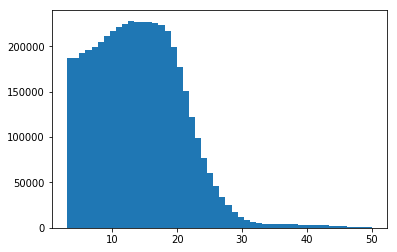

In [107]:
plt.hist(filtered['speed_mph'], bins=50, range=(3,50));

In [318]:
def make_valid_mask(freq):

    valid_mask = (se_gps_data_hour_prev_next[:,5] >= freq) & \
    (se['speed_mph'] != np.inf) & \
    (~np.isnan(se_gps_data_hour_prev_next[:,8])) & \
    (~np.isnan(se_gps_data_hour_prev_next[:,4])) & \
    (se_gps_data_hour_prev_next[:,11] != 0)
    
    return valid_mask

In [313]:
v_mask = make_valid_mask(8)

print(len(v_mask))

print(np.count_nonzero(v_mask))

print(np.count_nonzero(v_mask)/len(v_mask)*100)

3920087
2895912
73.87366657933867


In [110]:
# 0 slow_fraction
# 1 fast_hmean
# 2 fast_mean
# 3 total_mean
# 4 clipped_hmean
# 5 clipped_mean
# 6 freq_total
# 7 freq_fast
# 8 freq_clipped
# 9 fast_median
# 10 fast_75th percential
# 11 total_median
# 12 total_75th percential
# 13 max

overlaps_dict = {}
overlaps_dict[0] = []
overlaps_dict[1] = [4, 5, 11, 9, 12]
overlaps_dict[2] = [3, 10, 9]
overlaps_dict[3] = [2, 10, 12]
overlaps_dict[4] = [1, 5]
overlaps_dict[5] = [1, 4]
overlaps_dict[6] = [7, 8]
overlaps_dict[7] = [6, 8]
overlaps_dict[8] = [6, 7]
overlaps_dict[9] = [1, 2, 10, 12]
overlaps_dict[10] = [2, 9, 3]
overlaps_dict[11] = [1, 12]
overlaps_dict[12] = [1, 3, 9, 11]
overlaps_dict[13] = []
overlaps_dict[14] = []
overlaps_dict[15] = []


In [111]:
def make_overlap_mask(width = 17):
    overlaps_mask = np.zeros(width)

    overlaps_mask[:] = -1
    
    overlaps_mask[11] = 1 # 11 total_median
    overlaps_mask[4] = 1 # 4 clipped_hmean
    overlaps_mask[3] = 1 # 3 total_mean
    
    while(np.isin([-1], overlaps_mask).any()):
        options = np.where(overlaps_mask < 0)[0]
    #     print(options)
        i = np.random.randint(len(options))
#         print(i)
        overlaps_mask[options[i]] = 1
        overlaps_mask[overlaps_dict[options[i]]] = 0

    return overlaps_mask.astype(bool)
    


In [112]:
def best_overlap_mask(freq, data, columns):

    df_cors = pd.DataFrame(data=np.hstack((data, se[['speed_mph']].values)),
                        columns=columns)

    cors = df_cors[df_cors['freq_fast'] >= freq].corr()
    
    overlaps_dict = {}

    abs_cor_top_75th = np.percentile(np.abs(cors.values), 75)

    for col_idx, column in enumerate(cors.columns):

        if column == 'true_speed':
            continue

        overlaps_dict[column] = []

        for row_idx, (name, value) in enumerate(cors[column].iteritems()):
            if np.abs(value) > abs_cor_top_75th and column != name:
    #             print(f"{column} -> {name}: {value}")
                overlaps_dict[column].append(row_idx)
        
    overlap_mask = np.empty(len(cors['true_speed']))

    overlap_mask[:] = -1

    for best in cors['true_speed'].abs().sort_values().index[::-1]:

        if(best == "true_speed"):
            continue

        best_idx = cors.columns.get_loc(best)

        if overlap_mask[best_idx] == -1:
            overlap_mask[best_idx] = 1
            overlap_mask[overlaps_dict[best]] = 0


    return overlap_mask[:-1]

In [113]:
train_speeds = se['speed_mph'][:int(len(se)*test_fraction)]

mean_speed = np.mean(train_speeds[np.isfinite(train_speeds)])
print(mean_speed)

19.807506642246715


In [149]:
data = se_gps_data_hour_prev_next[:,1:]

mask = make_valid_mask(10)

display(np.sum(np.isnan(data[mask]), axis=0))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [119]:
(baseline_array_cum, 
     actual_array_cum, 
     baseline_median_array_cum, 
     baseline_pass_count, 
     pass_fraction, 
     baseline_median_pass_count, 
     median_pass_fraction) = calc_baseline_and_actual(se[int(len(se)*test_fraction):])

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


In [150]:
# def learn(freq, dropout, loss, NN, use_linear = False):
    
#     valid_mask = make_valid_mask(freq)
    
# #     data = np.hstack((se_gps_data_hour_prev_next[:,1:], se[['real_length', 
# #                                                             'direction_degrees', 
# #                                                             "to_centre_dist",
# #                                                            'rain',
# #                                                            'arrival_hour',
# #                                                            'arrival_day'
# #                                                            ]].values))

# #     overlaps_mask = best_overlap_mask(freq, data, ['slow_fraction', 'fast_hmean', 'fast_mean', 'total_mean',
# #                                     'clipped_hmean','clipped_mean','freq_total',
# #                                     'freq_fast','freq_clipped', 
# #                                    'fast_median', 'fast_75th percential',
# #                                   'total_median', 'total_75th percential', 'max', 
# #                                  'real_length', 'direction_degrees', "to_centre_dist",
# #                                                            'rain',
# #                                                            'arrival_hour',
# #                                                            'arrival_day','true_speed'])


#     data = se_gps_data_hour_prev_next[:,1:]

#     overlaps_mask = best_overlap_mask(freq, data, ['slow_fraction', 'fast_hmean', 'fast_mean', 'total_mean',
#                                     'freq_total',
#                                     'freq_fast',
#                                    'fast_median', 'fast_75th percential',
#                                   'total_median', 'total_75th percential', 'max','std', 
#                                     'true_speed'])

    
#     # where on the reduced (valid mask) data is the right place to cut so that when it comes back
#     # it's exactly test_fraction from the start
#     cut_point_valid = np.count_nonzero(valid_mask[:int(len(se)*test_fraction)])
    
# #     speeds_mph_simple = se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237
    
# #     (train_data_scaled, test_data_scaled, 
# #      train_target_scaled_baseline, test_target_scaled_baseline, 
# #      scaler_target_baseline) = prep_training_data(data[valid_mask,:][:, (overlaps_mask==1)], speeds_mph_simple[valid_mask], cut_point_valid)


#     (train_data_scaled, test_data_scaled, 
#      train_target_scaled, test_target_scaled, 
#      scaler_target) = prep_training_data(data[valid_mask,:][:, (overlaps_mask==1)], se[valid_mask]['speed_mph'], cut_point_valid)

#     print(overlaps_mask)
    
#     model = create_simple_model(
#             (train_data_scaled.shape[1]),
#             dropout, NN, use_linear)

#     Path(f"GPS_models").mkdir(parents=True, exist_ok=True)

#     callbacks_list = [
#         keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
#         keras.callbacks.ModelCheckpoint(
#             filepath=f"GPS_models/freq_{freq}_mask_{overlaps_mask}_simple_[{'_'.join(list(map(str, NN)))}]_{loss}_{dropout}_{use_linear}.h5",
#             monitor="val_loss",
#             save_best_only=True,
#         ),
#     ]

#     # model.compile(optimizer="rmsprop", loss="mean_absolute_error")
# #     model.compile(optimizer="rmsprop", loss="logcosh")
#     model.compile(optimizer="rmsprop", loss=loss)
#     model.fit(
#         train_data_scaled,
#         train_target_scaled,
#         epochs=100,
#         callbacks=callbacks_list,
#         batch_size=256,
#         validation_data=(test_data_scaled, test_target_scaled),
#     )

#     test_y_scaled = model.predict(test_data_scaled)

#     test_y = (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]

#     test_y[valid_mask[int(len(se)*test_fraction):]] = scaler_target.inverse_transform(test_y_scaled)
    
#     test_target_truth = se['speed_mph'][int(len(se)*test_fraction):]
    
#     test_target_truth[~np.isfinite(test_target_truth)] = mean_speed

#     RMSE = np.sqrt(mean_squared_error(test_target_truth, test_y))
    
#     MAE = mean_absolute_error(test_target_truth, test_y)
    
#     print(f"RMSE pred: {np.sqrt(mean_squared_error(test_target_truth, test_y))}")
#     print(f"RMSE base: {np.sqrt(mean_squared_error(test_target_truth, (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]))}")
#     print(f"RMSE base_median: {np.sqrt(mean_squared_error(test_target_truth, (se['real_length'] / se['median_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]))}")

#     print(f"MAE pred: {mean_absolute_error(test_target_truth, test_y)}")
#     print(f"MAE base: {mean_absolute_error(test_target_truth, (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):])}")
#     print(f"MAE base_median: {mean_absolute_error(test_target_truth, (se['real_length'] / se['median_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):])}")
    
#     predict_array_NN_cum, _, pass_fraction = calc_prediction_cum_journeys(se[int(len(se)*test_fraction):], test_y, baseline_array_cum, actual_array_cum)

#     return overlaps_mask, pass_fraction, RMSE, MAE, test_y, predict_array_NN_cum

In [328]:
def learn_PCA(freq, dropout, loss, NN, days, extra_features = False, use_linear = False):
    
    valid_mask = make_valid_mask(freq)
    
    if extra_features:
        data = np.hstack((se_gps_data_hour_prev_next[:,1:], se[['real_length', 
                                                                'direction_degrees', 
                                                                "to_centre_dist",
                                                               'rain',
                                                            "timetable_segment_duration",
                                                            "std_diff_percent_segment_mean_by_segment_code_and_hour_and_day",
                                                            "clock_direction_degrees",
                                                            "dry",
                                                            "weekend",
                                                               ]].values, pd.get_dummies(se[["arrival_hour", "arrival_day"]])))
    else: 
        data = se_gps_data_hour_prev_next[:,1:]

    (train_data_scaled, test_data_scaled, 
     train_target_scaled, test_target_scaled, 
     scaler_target) = prep_training_data_days(data, se['speed_mph'], days, valid_mask)
    
    pca = PCA(n_components=0.95, svd_solver = 'full')
    
    GPS_feature_width =  se_gps_data_hour_prev_next[:,1:].shape[1]
    
    train_data_scaled = np.hstack((pca.fit_transform(train_data_scaled[:,:GPS_feature_width]), train_data_scaled[:,GPS_feature_width:]))
    test_data_scaled = np.hstack((pca.transform(test_data_scaled[:,:GPS_feature_width]), test_data_scaled[:,GPS_feature_width:]))
    
    print(f"Using {len(pca.explained_variance_)} PCA components")
    
    model = create_simple_model(
            (train_data_scaled.shape[1]),
            dropout, NN, use_linear)

    Path(f"GPS_models").mkdir(parents=True, exist_ok=True)

    callbacks_list = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
        keras.callbacks.ModelCheckpoint(
            filepath=f"GPS_models/freq_{freq}_pca_{len(pca.explained_variance_)}_simple_[{'_'.join(list(map(str, NN)))}]_{loss}_{dropout}_{use_linear}.h5",
            monitor="val_loss",
            save_best_only=True,
        ),
    ]

    # model.compile(optimizer="rmsprop", loss="mean_absolute_error")
#     model.compile(optimizer="rmsprop", loss="logcosh")
    model.compile(optimizer="rmsprop", loss=loss)
    model.fit(
        train_data_scaled,
        train_target_scaled,
        epochs=100,
        callbacks=callbacks_list,
        batch_size=256,
        validation_data=(test_data_scaled, test_target_scaled),
    )

    test_y_scaled = model.predict(test_data_scaled)

    test_y = (se.loc[se['test'], 'real_length'] / se.loc[se['test'],'mean_durations_by_segment_code_and_hour_and_day'] * 2.237)

    test_y[valid_mask & se['test']] = scaler_target.inverse_transform(test_y_scaled)
    
    test_target_truth = se.loc[se['test'], 'speed_mph']
    
    test_target_truth[~np.isfinite(test_target_truth)] = mean_speed
    
    test_y_duration = se.loc[se['test'], 'real_length'] / test_y * 2.237
    
    return test_y_duration


In [133]:
# def learn_KNN(freq=10, k=5):
    
#     valid_mask = make_valid_mask(freq)
    
#     data = se_gps_data_hour_prev_next[:,1:]

#     overlaps_mask = best_overlap_mask(freq, data, ['slow_fraction', 'fast_hmean', 'fast_mean', 'total_mean',
#                                     'freq_total',
#                                     'freq_fast','freq_clipped', 
#                                    'fast_median', 'fast_75th percential',
#                                   'total_median', 'total_75th percential', 'max', 'std', 
#                                     'true_speed'])

    
#     # where on the reduced (valid mask) data is the right place to cut so that when it comes back
#     # it's exactly test_fraction from the start
#     cut_point_valid = np.count_nonzero(valid_mask[:int(len(se)*test_fraction)])
    
# #     speeds_mph_simple = se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237
    
# #     (train_data_scaled, test_data_scaled, 
# #      train_target_scaled_baseline, test_target_scaled_baseline, 
# #      scaler_target_baseline) = prep_training_data(data[valid_mask,:][:, (overlaps_mask==1)], speeds_mph_simple[valid_mask], cut_point_valid)


#     (train_data_scaled, test_data_scaled, 
#      train_target_scaled, test_target_scaled, 
#      scaler_target) = prep_training_data(data[valid_mask,:][:, (overlaps_mask==1)], se[valid_mask]['speed_mph'], cut_point_valid)

#     neigh = KNeighborsRegressor(n_neighbors=k, weights="distance")
#     neigh.fit(train_data_scaled, train_target_scaled) 

#     test_y_scaled = neigh.predict(test_data_scaled)

#     test_y = (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]

#     test_y[valid_mask[int(len(se)*test_fraction):]] = scaler_target.inverse_transform(test_y_scaled)
    
#     test_target_truth = se['speed_mph'][int(len(se)*test_fraction):]
    
#     test_target_truth[~np.isfinite(test_target_truth)] = mean_speed

#     RMSE = np.sqrt(mean_squared_error(test_target_truth, test_y))
    
#     MAE = mean_absolute_error(test_target_truth, test_y)
    
#     print(f"RMSE pred: {np.sqrt(mean_squared_error(test_target_truth, test_y))}")
#     print(f"RMSE base: {np.sqrt(mean_squared_error(test_target_truth, (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]))}")
#     print(f"RMSE base_median: {np.sqrt(mean_squared_error(test_target_truth, (se['real_length'] / se['median_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]))}")

#     print(f"MAE pred: {mean_absolute_error(test_target_truth, test_y)}")
#     print(f"MAE base: {mean_absolute_error(test_target_truth, (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):])}")
#     print(f"MAE base_median: {mean_absolute_error(test_target_truth, (se['real_length'] / se['median_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):])}")

    
#     predict_array_NN_cum, _, pass_fraction = calc_prediction_cum_journeys(se[int(len(se)*test_fraction):], test_y, baseline_array_cum, actual_array_cum)

#     return overlaps_mask, pass_fraction, RMSE, MAE, test_y, predict_array_NN_cum

In [320]:
stats = Stats(se[se['test']])

../../pipeline/utils/stats.py:20: RuntimeWarning: invalid value encountered in less
  self.first_20mins_mask = actual_array_cum < 20 * 60


In [173]:
# _, _, _, _, test_y, predict_array_KNN_cum = learn_KNN(10, 5)

In [206]:
# _, _, _, _, test_y, predict_array_NN_cum = learn(10, 0.0, "logcosh", [64,32,12], False)

# Draw real vs streight length for messages - Yes
# Try using straight lengths for the messages instead - Bad
# Try using a linear instead of tanh activation for the last layer - Worse
# Try predicting the mean and then still testing against true, for various networks
# Try to find one bus route where this works really well

In [331]:
# _, _, _, test_y, predict_array_NN_PCA_cum, wraw_prediction = learn_PCA(10, 0.3, "logcosh", [128,62,32,12], 20, True)
predict = learn_PCA(8, 0, "logcosh", [128,62,32,12], 10, False, False)

stats.single_row(predict, "logcosh", data_type="duration")


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
dense_423 (Dense)            (None, 128)               896       
_________________________________________________________________
dropout_423 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_424 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_424 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_425 (Dense)            (None, 62)                7998      
_________________________________________________________________
dropout_425 (Dropout)        (None, 62)              

'logcosh & 35.932 & 40.621 & 18.191 & 21.095 & 20.857 & 241.694 & 153.071 & 31.657 \\\\\n'

In [334]:
stats = Stats(se[se['test']])

with open("GPS_fixed_true_dist_PCA_learning_curve_valid_freq.csv", "a+") as f: 
#     f.write(stats.full_stats(tests=[], names=[], data_type="duration"))
#     f.flush()
    for runs in range(5):
        for NN in [[32,12,12],[128,64,32,12]]: # [64,32,12], [128,64,32,32,12]]:
            for dropout in [0,0.2,0.5]:
                for days in [1,5,10,30,50,70]:
                    for loss in ['logcosh']: # , 'mean_absolute_error', 'mean_squared_error']:
                        for freq in [10, 12]:
                            for use_linear in [False]:
                                for extra_features in [True, False]:
                    
                                    prediction = learn_PCA(freq, dropout, loss, NN, days, extra_features, use_linear)
        #                             f.write(f"{freq},{dropout},{loss},{'_'.join(list(map(str,overlaps_mask)))},{'_'.join(list(map(str,NN)))},{use_linear},{pass_fraction},{RMSE},{MAE}\n")
        #                             f.flush()
                                    f.write(
                                        stats.single_row(
                                            prediction,
                                            f"features_{extra_features}_linear_{use_linear}_days_{days}_dropout_{dropout}_freq_{freq}_NN_{'_'.join(list(map(str,NN)))}",
                                            data_type="duration",
                                        )
                                    )
                                    f.flush()


../../pipeline/utils/stats.py:20: RuntimeWarning: invalid value encountered in less
  self.first_20mins_mask = actual_array_cum < 20 * 60
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 5 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
dense_807 (Dense)            (None, 32)                544       
_________________________________________________________________
dropout_713 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_808 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_714 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_809 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_715 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 5 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
dense_815 (Dense)            (None, 32)                544       
_________________________________________________________________
dropout_719 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_816 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_720 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_817 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_721 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_823 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_725 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_824 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_726 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_825 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_727 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_831 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_731 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_832 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_732 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_833 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_733 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_839 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_737 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_840 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_738 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_841 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_739 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_847 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_743 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_848 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_744 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_849 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_745 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_855 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_749 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_856 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_750 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_857 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_751 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_863 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_755 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_864 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_756 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_865 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_757 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_871 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_761 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_872 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_762 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_873 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_763 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_879 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_767 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_880 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_768 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_881 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_769 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_887 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_773 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_888 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_774 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_889 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_775 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_895 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_779 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_896 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_780 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_897 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_781 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 5 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
dense_903 (Dense)            (None, 32)                544       
_________________________________________________________________
dropout_785 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_904 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_786 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_905 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_787 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 5 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
dense_911 (Dense)            (None, 32)                544       
_________________________________________________________________
dropout_791 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_912 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_792 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_913 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_793 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_919 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_797 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_920 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_798 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_921 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_799 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_927 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_803 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_928 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_804 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_929 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_805 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_935 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_809 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_936 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_810 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_937 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_811 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_943 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_815 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_944 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_816 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_945 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_817 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_951 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_821 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_952 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_822 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_953 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_823 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_959 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_827 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_960 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_828 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_961 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_829 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_967 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_833 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_968 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_834 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_969 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_835 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_975 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_839 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_976 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_840 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_977 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_841 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_983 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_845 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_984 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_846 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_985 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_847 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_991 (Dense)            (None, 32)                576       
_________________________________________________________________
dropout_851 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_992 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_852 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_993 (Dense)            (None, 12)                396       
_________________________________________________________________
dropout_853 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 5 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
dense_999 (Dense)            (None, 32)                544       
_________________________________________________________________
dropout_857 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1000 (Dense)           (None, 32)                1056      
_________________________________________________________________
dropout_858 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1001 (Dense)           (None, 12)                396       
_________________________________________________________________
dropout_859 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 5 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
dense_1007 (Dense)           (None, 32)                544       
_________________________________________________________________
dropout_863 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1008 (Dense)           (None, 32)                1056      
_________________________________________________________________
dropout_864 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1009 (Dense)           (None, 12)                396       
_________________________________________________________________
dropout_865 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1015 (Dense)           (None, 32)                576       
_________________________________________________________________
dropout_869 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1016 (Dense)           (None, 32)                1056      
_________________________________________________________________
dropout_870 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1017 (Dense)           (None, 12)                396       
_________________________________________________________________
dropout_871 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1023 (Dense)           (None, 32)                576       
_________________________________________________________________
dropout_875 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1024 (Dense)           (None, 32)                1056      
_________________________________________________________________
dropout_876 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1025 (Dense)           (None, 12)                396       
_________________________________________________________________
dropout_877 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1031 (Dense)           (None, 32)                576       
_________________________________________________________________
dropout_881 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1032 (Dense)           (None, 32)                1056      
_________________________________________________________________
dropout_882 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1033 (Dense)           (None, 12)                396       
_________________________________________________________________
dropout_883 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1039 (Dense)           (None, 32)                576       
_________________________________________________________________
dropout_887 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1040 (Dense)           (None, 32)                1056      
_________________________________________________________________
dropout_888 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1041 (Dense)           (None, 12)                396       
_________________________________________________________________
dropout_889 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1047 (Dense)           (None, 32)                576       
_________________________________________________________________
dropout_893 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1048 (Dense)           (None, 32)                1056      
_________________________________________________________________
dropout_894 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1049 (Dense)           (None, 12)                396       
_________________________________________________________________
dropout_895 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1055 (Dense)           (None, 32)                576       
_________________________________________________________________
dropout_899 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1056 (Dense)           (None, 32)                1056      
_________________________________________________________________
dropout_900 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1057 (Dense)           (None, 12)                396       
_________________________________________________________________
dropout_901 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1063 (Dense)           (None, 32)                576       
_________________________________________________________________
dropout_905 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1064 (Dense)           (None, 32)                1056      
_________________________________________________________________
dropout_906 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1065 (Dense)           (None, 12)                396       
_________________________________________________________________
dropout_907 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1071 (Dense)           (None, 32)                576       
_________________________________________________________________
dropout_911 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1072 (Dense)           (None, 32)                1056      
_________________________________________________________________
dropout_912 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1073 (Dense)           (None, 12)                396       
_________________________________________________________________
dropout_913 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1079 (Dense)           (None, 32)                576       
_________________________________________________________________
dropout_917 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1080 (Dense)           (None, 32)                1056      
_________________________________________________________________
dropout_918 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1081 (Dense)           (None, 12)                396       
_________________________________________________________________
dropout_919 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1087 (Dense)           (None, 32)                576       
_________________________________________________________________
dropout_923 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1088 (Dense)           (None, 32)                1056      
_________________________________________________________________
dropout_924 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_1089 (Dense)           (None, 12)                396       
_________________________________________________________________
dropout_925 (Dropout)        (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 5 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
dense_1095 (Dense)           (None, 128)               2176      
_________________________________________________________________
dropout_929 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1096 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_930 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1097 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_931 (Dropout)        (None, 64)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 5 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
dense_1105 (Dense)           (None, 128)               2176      
_________________________________________________________________
dropout_937 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1106 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_938 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1107 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_939 (Dropout)        (None, 64)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1115 (Dense)           (None, 128)               2304      
_________________________________________________________________
dropout_945 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1116 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_946 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1117 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_947 (Dropout)        (None, 64)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1125 (Dense)           (None, 128)               2304      
_________________________________________________________________
dropout_953 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1126 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_954 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1127 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_955 (Dropout)        (None, 64)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1135 (Dense)           (None, 128)               2304      
_________________________________________________________________
dropout_961 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1136 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_962 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1137 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_963 (Dropout)        (None, 64)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1145 (Dense)           (None, 128)               2304      
_________________________________________________________________
dropout_969 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1146 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_970 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1147 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_971 (Dropout)        (None, 64)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1155 (Dense)           (None, 128)               2304      
_________________________________________________________________
dropout_977 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1156 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_978 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1157 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_979 (Dropout)        (None, 64)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1165 (Dense)           (None, 128)               2304      
_________________________________________________________________
dropout_985 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1166 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_986 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1167 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_987 (Dropout)        (None, 64)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1175 (Dense)           (None, 128)               2304      
_________________________________________________________________
dropout_993 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1176 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_994 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_1177 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_995 (Dropout)        (None, 64)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1185 (Dense)           (None, 128)               2304      
_________________________________________________________________
dropout_1001 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1186 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_1002 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1187 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_1003 (Dropout)       (None, 64)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1195 (Dense)           (None, 128)               2304      
_________________________________________________________________
dropout_1009 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1196 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_1010 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1197 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_1011 (Dropout)       (None, 64)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1205 (Dense)           (None, 128)               2304      
_________________________________________________________________
dropout_1017 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1206 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_1018 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1207 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_1019 (Dropout)       (None, 64)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 5 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
dense_1215 (Dense)           (None, 128)               2176      
_________________________________________________________________
dropout_1025 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1216 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_1026 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1217 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_1027 (Dropout)       (None, 64)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 5 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
dense_1225 (Dense)           (None, 128)               2176      
_________________________________________________________________
dropout_1033 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1226 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_1034 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1227 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_1035 (Dropout)       (None, 64)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1235 (Dense)           (None, 128)               2304      
_________________________________________________________________
dropout_1041 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1236 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_1042 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1237 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_1043 (Dropout)       (None, 64)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1245 (Dense)           (None, 128)               2304      
_________________________________________________________________
dropout_1049 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1246 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_1050 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1247 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_1051 (Dropout)       (None, 64)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1255 (Dense)           (None, 128)               2304      
_________________________________________________________________
dropout_1057 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1256 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_1058 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1257 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_1059 (Dropout)       (None, 64)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Using 6 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 17)                0         
_________________________________________________________________
dense_1265 (Dense)           (None, 128)               2304      
_________________________________________________________________
dropout_1065 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1266 (Dense)           (None, 128)               16512     
_________________________________________________________________
dropout_1066 (Dropout)       (None, 128)               0         
_________________________________________________________________
dense_1267 (Dense)           (None, 64)                8256      
_________________________________________________________________
dropout_1067 (Dropout)       (None, 64)              

KeyboardInterrupt: 

In [ ]:
# plt.hist(np.clip(wraw_prediction, 0, 50), bins=100, range=(0,50));

In [ ]:
# plt.hist(se['speed_mph'], bins=100, range=(0,50));

In [ ]:
# plt.hist(test_y, bins=100, label="pred", density=True, range=(-10,100));
# plt.hist(se['speed_mph'][int(len(se)*test_fraction):], bins=100, label="truth", alpha=0.5, density=True, range=(-10,100));
# plt.legend()

In [ ]:
# speeds_mph_simple = se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237

# se_min = se[['speed_mph', 'publicName', 'to_centre_dist', 'real_length', 'mean_durations_by_segment_code_and_hour_and_day']][int(len(se)*test_fraction):].copy()

# se_min['baseline_speed'] = se_min['real_length'] / se_min['mean_durations_by_segment_code_and_hour_and_day'] * 2.237

# se_min['test_y'] = test_y

# routes = []
# pred_MSE = []
# pred_RMSE = []
# base_MSE = []
# base_RMSE = []
# freq = []
# mean_dist = []

# for route_name, route in se_min.groupby('publicName'):
    
#     if route_name in schools:
#         continue
        
#     routes.append(route_name)
#     pred_MSE.append(mean_absolute_error(route['speed_mph'], route['test_y']))
#     pred_RMSE.append(np.sqrt(mean_squared_error(route['speed_mph'], route['test_y'])))
#     base_MSE.append(mean_absolute_error(route['speed_mph'], route['baseline_speed']))
#     base_RMSE.append(np.sqrt(mean_squared_error(route['speed_mph'], route['baseline_speed'])))
#     freq.append(len(route))
    
# results = pd.DataFrame(index=routes)
# results['pred_MSE'] = pred_MSE
# results['base_MSE'] = base_MSE
# results['pred_RMSE'] = pred_RMSE
# results['base_RMSE'] = base_RMSE
# results['freq'] = freq